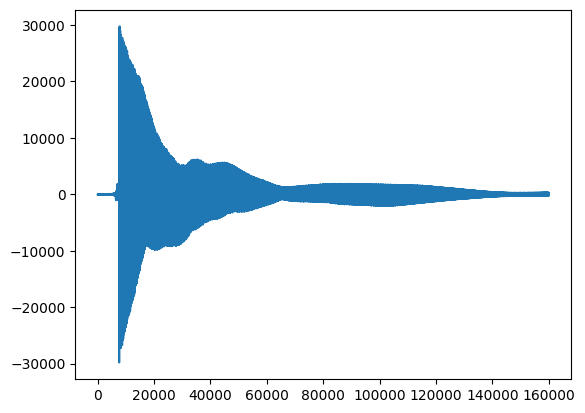

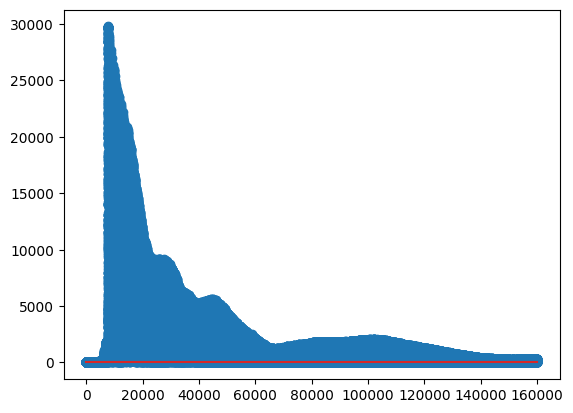

In [44]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read, write

def read_wave(filename):
    return read(filename)

samplerate, data = read_wave("sounds/note_guitare_LAd.wav")
plt.plot(data)
plt.show()

plt.stem(np.abs(data))
plt.show()

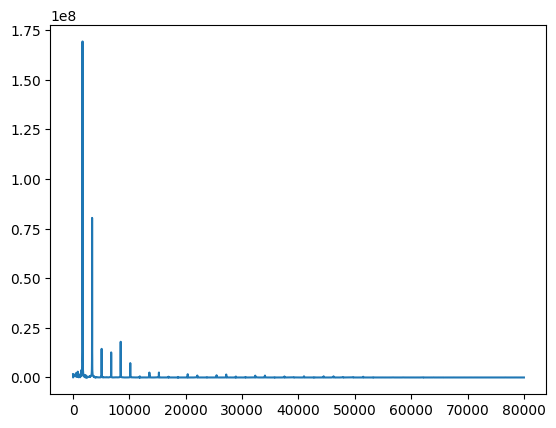

1690
465.80625000000003


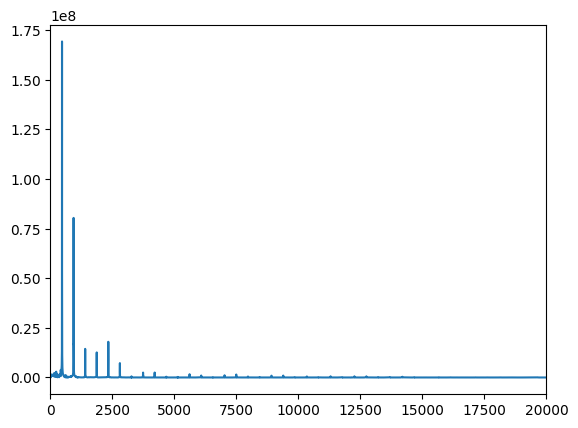

In [45]:
fft_spect = np.fft.rfft(data)
arr_freq = np.fft.rfftfreq(data.size, d=1./samplerate)
amp_fft_spect = np.abs(fft_spect)
phase_fft_spect = np.angle(fft_spect)

# normalisation
# amp_fft_spect /= np.max(amp_fft_spect)

plt.plot(amp_fft_spect)
plt.show()

print(np.argmax(amp_fft_spect))
print(arr_freq[np.argmax(amp_fft_spect)])

plt.plot(arr_freq, amp_fft_spect)
plt.xlim(0, 20000)
plt.show()

In [46]:
# Aller chercher les 32 plus grosses amp et leur freq
N = 32
inx = np.argpartition(amp_fft_spect, -N)[-N:]
for i in inx:
    print(f"freq : {arr_freq[i]}, amp : {amp_fft_spect[i]}")

freq : 468.838125, amp : 29291929.822904717
freq : 933.541875, amp : 29579834.692570314
freq : 468.5625, amp : 32796276.255962472
freq : 932.990625, amp : 48834826.05739732
freq : 462.774375, amp : 34352644.6758002
freq : 463.05, amp : 42764113.12925267
freq : 463.325625, amp : 44862843.1437224
freq : 463.60125, amp : 45987730.867182806
freq : 463.87687500000004, amp : 49802114.89755988
freq : 464.15250000000003, amp : 54071227.75351646
freq : 464.428125, amp : 62492682.691254415
freq : 464.70375, amp : 72452553.03295659
freq : 464.979375, amp : 106144815.76269075
freq : 465.255, amp : 163472292.12083298
freq : 465.53062500000004, amp : 164053255.92373997
freq : 465.80625000000003, amp : 169185361.50801417
freq : 466.081875, amp : 76250700.26279785
freq : 466.3575, amp : 47723903.91935021
freq : 466.633125, amp : 68345845.883543
freq : 466.90875, amp : 68666444.10384777
freq : 467.184375, amp : 61782004.7774034
freq : 467.46000000000004, amp : 53456286.40120906
freq : 467.735625, amp :

[  465.80625   931.6125   1397.41875  1863.225    2329.03125  2794.8375
  3260.64375  3726.45     4192.25625  4658.0625   5123.86875  5589.675
  6055.48125  6521.2875   6987.09375  7452.9      7918.70625  8384.5125
  8850.31875  9316.125    9781.93125 10247.7375  10713.54375 11179.35
 11645.15625 12110.9625  12576.76875 13042.575   13508.38125 13974.1875
 14439.99375 14905.8    ]


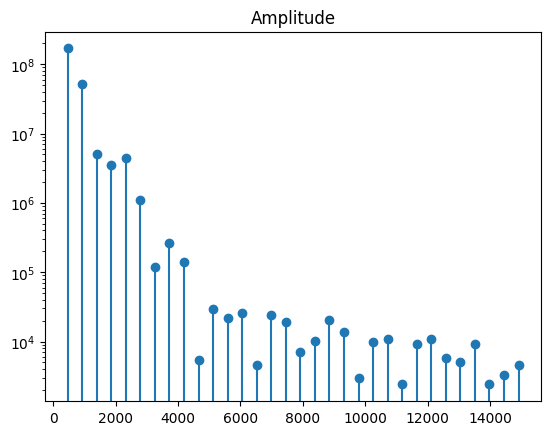

In [47]:
# Frequences fondamentales
freq_fondamentale = arr_freq[np.argmax(amp_fft_spect)] 
freq_harmoniques = np.arange(freq_fondamentale, (N + 1)*freq_fondamentale, freq_fondamentale)
print(freq_harmoniques) 

# Find nearest freq_harmoniques in freq
#  where is freq_f in freq ?
def find_nearest_idx(arr, val):
    arr = np.asarray(arr)
    return (np.abs(arr - val)).argmin()

real_freq_harmoniques = []
arr_amp_n = []
arr_phase_n = []

for f_h in freq_harmoniques:
    idx = find_nearest_idx(arr_freq, f_h)
    real_freq_harmoniques.append(arr_freq[idx])
    arr_amp_n.append(amp_fft_spect[idx])
    arr_phase_n.append(phase_fft_spect[idx])
    

plt.stem(real_freq_harmoniques,  arr_amp_n)
plt.title('Amplitude')
plt.yscale('log')
plt.show()



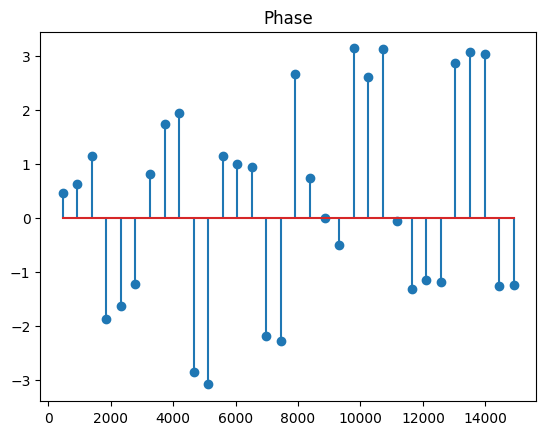

In [48]:
plt.stem(real_freq_harmoniques, arr_phase_n)
plt.title('Phase')
plt.show()

In [69]:
def create_note(harmoniques, arr_amp, arr_phase, samplerate, filename):
    length = 3

    t = np.linspace(0, length, samplerate * length)
    y = 0

    for i, f in enumerate(harmoniques):
        y += arr_amp[i]*np.sin(f * 2 * np.pi * t + arr_phase[i]) 

    write(f"sounds/notes/{filename}.wav", samplerate, y.astype(np.int32))

# Creation A#
create_note(real_freq_harmoniques, arr_amp_n, arr_phase_n, samplerate, 'A#')


In [70]:
# Creation de toutes les notes
notes_names = [ 'A', 'G#', 'G', 'F#', 'F', 'E', 'R#','R', 'C#', 'C', 'B' ]
notes = {}
for i, n in enumerate(notes_names, 1):
    notes[n] = -i

notes[notes_names[len(notes_names)-1]] = 1

In [74]:
for k in notes:
    facteur = pow(2, notes[k] / 12)
    note_harmoniques = np.multiply(real_freq_harmoniques, facteur)
    create_note(note_harmoniques, arr_amp_n, arr_phase_n, samplerate, k)

Coupe-bande 1000 kHz

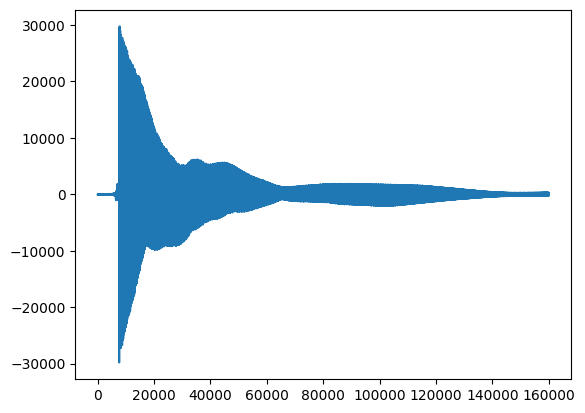

In [76]:
samplerate, data = read_wave("sounds/note_guitare_LAd.wav")
plt.plot(data)
plt.show()

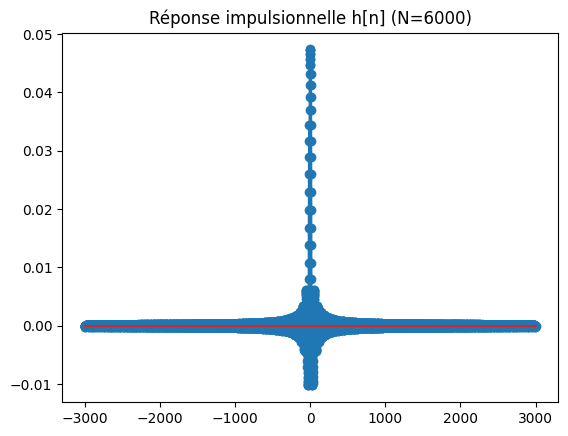

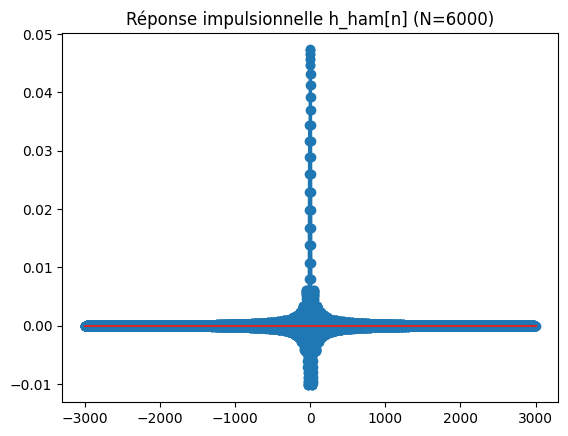

In [83]:
N = 6000
fc = 1040
fe = samplerate 

n = np.arange(0 - (N / 2), (N / 2))
m = N * (fc / fe)
k = 2 * m + 1

# Reponse impulsionnelle du filtre passe-bas
h_lp = [1 / N * (np.sin(math.pi * n[i] * k / N) / np.sin(math.pi * n[i] / N)) if n[i] != 0 else k/N for i in range(N)]
h_lp_ham = np.hamming(N) * h_lp

hfft_lp = np.fft.fft(h_lp)
h_db = [20 * np.log10(np.abs(x)) if x != 0 else 0 for x in hfft_lp]
w = [(i * 2 * math.pi) / (N) for i in range(N)]

# Representation
plt.title(f"Réponse impulsionnelle h[n] (N={N})")
plt.stem(n, h_lp)
plt.show()

plt.title(f"Réponse impulsionnelle h_ham[n] (N={N})")
plt.stem(n, h_lp_ham)
plt.show()


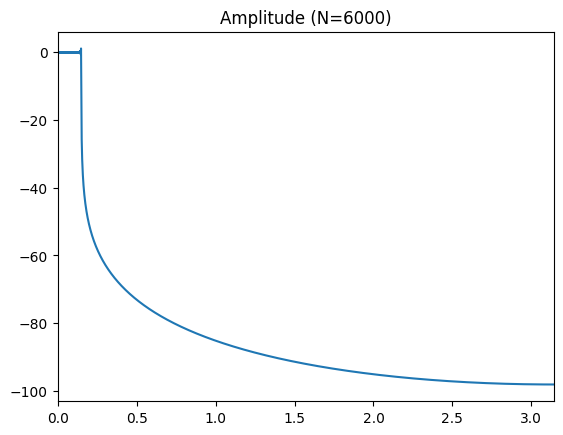

In [82]:
plt.title(f"Amplitude (N={N})")
plt.xlim(0, math.pi)
plt.plot(w, h_db)
plt.show()

Tests

In [ ]:
w = [(i * 2 * math.pi) / (N) for i in range(N)]
plt.yscale('log')
plt.plot(w, arr_amp_n)